# Process of Benchmarking data

In [10]:
from functions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

In [11]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

In [22]:
target_qubits = [0]
n_qubits = len(target_qubits)

epsilon = 0.01
# machine_title = '2q-qvm'
machine_title = 'Aspen-M-3'
# noise_model = 'depolarising_noise'
noisy_machine = machine_title

# noisy_machine = 'depolarising_noise' + '_epsilon{}'.format(epsilon)
# noise_model = 'z_noise'
path = os.path.join( os.getcwd(), 'output_storage', noisy_machine)

In [23]:
avg_fdlty_dict = {}
err_fdlty_dict = {}
ordered_layers_dict = {}

In [24]:
def capture_bench_dataframe(path):
    dataframe = pd.read_csv(os.path.join(path, '{}.csv'.format(machine_title) ) )
    dataframe = dataframe[dataframe['target qubits'] == str(target_qubits)]
    return dataframe

def capture_bench_arrays(dataframe, version_name):
    dataframe = dataframe[ dataframe['protocol name'] == version_name ]
    ordered_layers = dataframe['circuit depth']
    avg_fdlty_arr = dataframe['average of fidelity']
    err_fdlty_arr = dataframe['error of fidelity']
    return ordered_layers, avg_fdlty_arr, err_fdlty_arr

In [25]:
df = capture_bench_dataframe(path)
bench_versions = df['protocol name'].unique()
for version in bench_versions:
    avg_fdlty_dict[version] = {}
    err_fdlty_dict[version] = {}
    ordered_layers_dict[version] = {}

    try:
        ordered_layers, avg_fdlty_arr, err_fdlty_arr = capture_bench_arrays(df, version)
        avg_fdlty_dict[version].update({epsilon:avg_fdlty_arr})
        err_fdlty_dict[version].update({epsilon:err_fdlty_arr})
        ordered_layers_dict[version].update({epsilon:ordered_layers})
    except:
        pass

In [26]:
df.head()

,date,target qubits,number of sequences,number of shots,protocol name,circuit depth,average of fidelity,error of fidelity
0,2023-01-15,[0],50,50,native_conditional,0,0.9432,0.033072
1,2023-01-15,[0],50,50,native_conditional,1,0.9352,0.036783
2,2023-01-15,[0],50,50,native_conditional,2,0.9344,0.035336
3,2023-01-15,[0],50,50,native_conditional,3,0.9248,0.035679
4,2023-01-15,[0],50,50,native_conditional,4,0.9240,0.042521


In [27]:
# avg_fdlty_dict

In [28]:
def plot_bench_arrays(axes, version, epsilon):
    popt, pcov = extrapolate_decay_func( ordered_layers_dict[version][epsilon],
                                        avg_fdlty_dict[version][epsilon], err_fdlty_dict[version][epsilon])
    r = decay_param(popt[0], n_qubit)
    between_layers = np.arange(ordered_layers_dict[version][epsilon].min(),ordered_layers_dict[version][epsilon].max(),1).astype('int')
    
    axes.errorbar(ordered_layers_dict[version][epsilon], avg_fdlty_dict[version][epsilon],
                yerr = err_fdlty_dict[version][epsilon],
                fmt = 'o', color = 'k')
    axes.plot(between_layers, decay_func(between_layers, *popt),
              label = version + r': ${1}*{0}^m+{2}$'.format(*np.round(popt,5)))
    return


In [29]:
bench_versions

array(['native_conditional'], dtype=object)

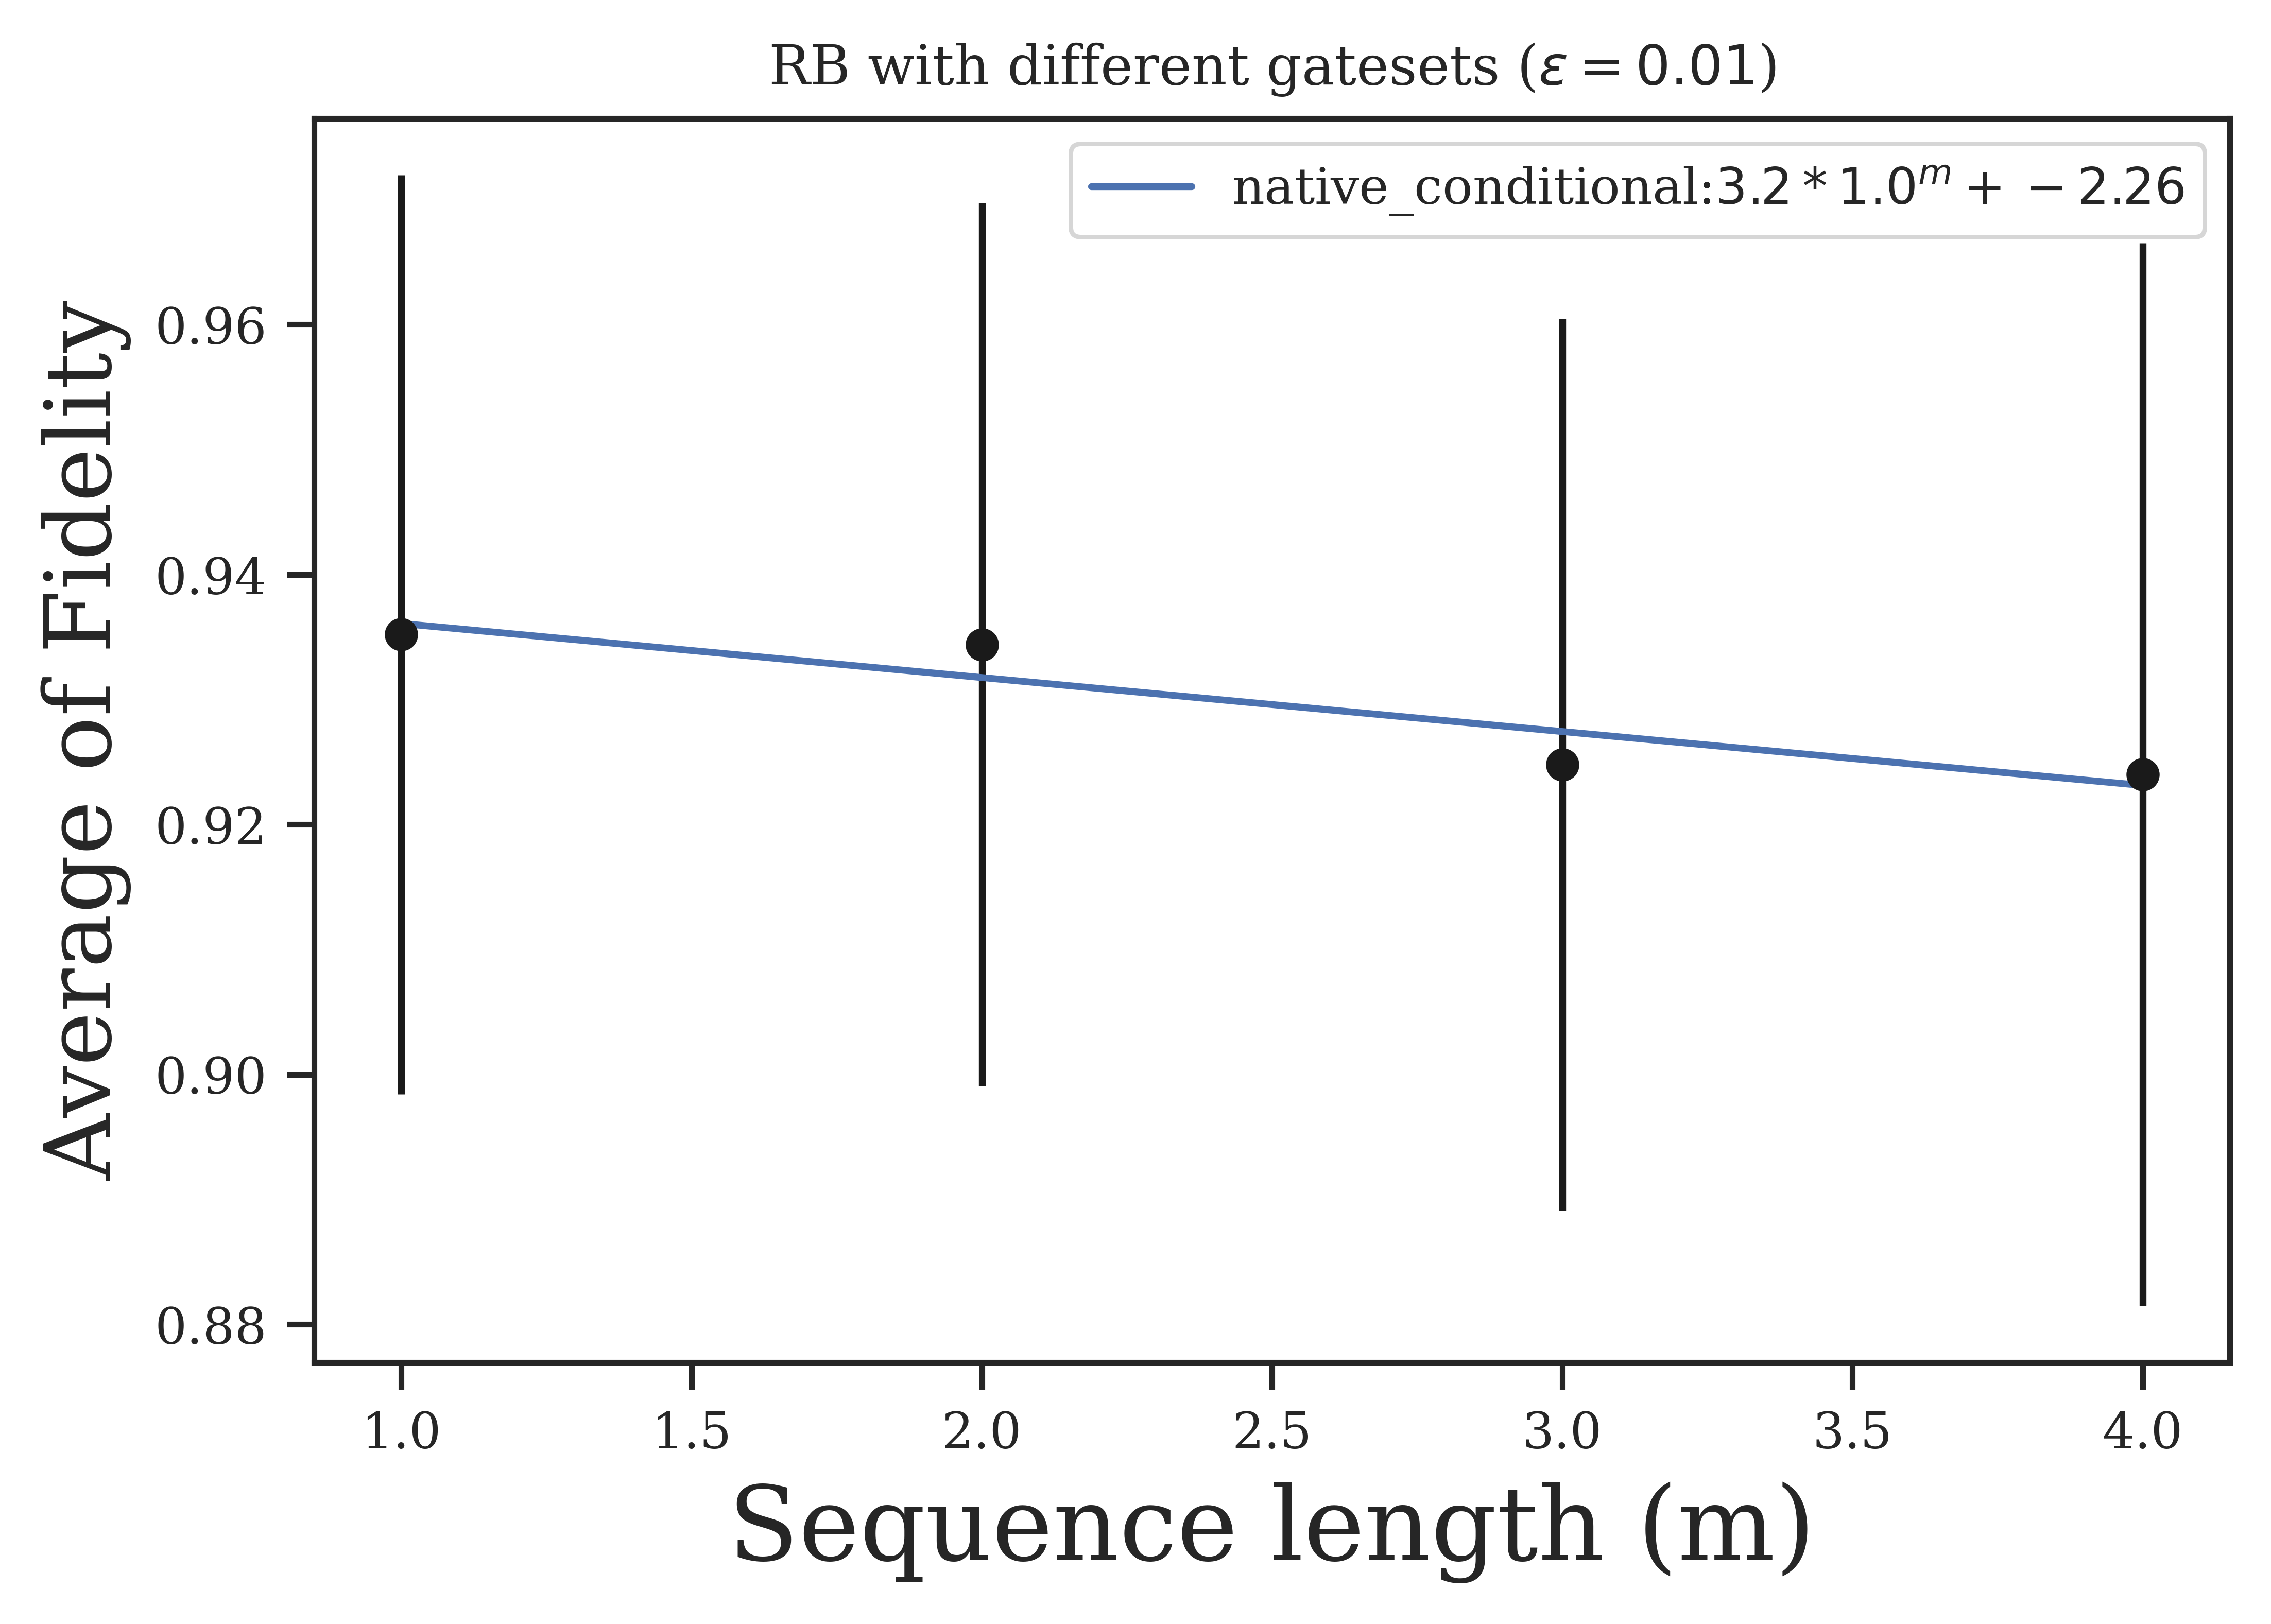

In [34]:
fig = plt.figure(dpi = 800)
ax = fig.add_subplot()

epsilon = 0.01

# for version in ['conditional_universal_circuit']:
for version in ['native_conditional']:
#     plot_bench_arrays(ax, version, epsilon)
    plot_decay(ordered_layers_dict[version][epsilon][1:], avg_fdlty_dict[version][epsilon][1:],
               err_fdlty_dict[version][epsilon][1:], label = version, axes = ax)

# plt.loglog()
ax.set_xlabel('Sequence length (m)', fontsize=18)
ax.set_ylabel('Average of Fidelity', fontsize=16)
ax.set_title(r'RB with different gatesets ($\epsilon = {}$)'.format(epsilon))

plt.legend()

fig.savefig(os.path.join(path, 'RB_comparison'+'.png'))
